In [ ]:
#Google Books scraper
#want to fee movie titles through and get related book info

In [ ]:
#https://www.google.com/books/edition/Harry_Potter_and_the_Goblet_of_Fire/e3_6vQEACAAJ?hl=en
#https://www.google.com/search?tbo=p&tbm=bks&q=intitle:Dune&tbs=,bkt:b&num=10
#https://www.google.com/books/edition/Dune_The_Butlerian_Jihad/1jkuHDLsiWkC?hl=en&gbpv=0

#be sure to get: characters (number?), part of a series?

#plan: search term with title and Movie tie in, if no results, then just title?
#spit out confidence check, too: title matches

#bad ones: the day of chocolate, Dune?
#Think Again, Junpei [Movie Tie-in]'

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import re

In [19]:
#this searches by wikipedia's fiction work description - has title, year, and author
firsturl = 'https://www.google.com/search?tbo=p&tbm=bks&q={},bkt:b&num=1'.format('The Accidental Tourist (1985), Anne Tyler')

# Request the page and use BeautifulSoup to extract the contents
page = requests.get(firsturl)
soup = BeautifulSoup(page.content, 'html.parser')


<!DOCTYPE html>
<html lang="en">
 <head>
  <meta charset="utf-8"/>
  <meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"/>
  <title>
   The Accidental Tourist (1985), Anne Tyler,bkt:b - Google Search
  </title>
  <script nonce="m01MmxW3ZT2RHL3qdI92iw==">
   (function(){
document.documentElement.addEventListener("submit",function(b){var a;if(a=b.target){var c=a.getAttribute("data-submitfalse");a="1"===c||"q"===c&&!a.elements.q.value?!0:!1}else a=!1;a&&(b.preventDefault(),b.stopPropagation())},!0);document.documentElement.addEventListener("click",function(b){var a;a:{for(a=b.target;a&&a!==document.documentElement;a=a.parentElement)if("A"===a.tagName){a="1"===a.getAttribute("data-nohref");break a}a=!1}a&&b.preventDefault()},!0);}).call(this);(function(){
var a=window.performance;window.start=Date.now();a:{var b=window;if(a){var c=a.timing;if(c){var d=c.navigationStart,f=c.responseStart;if(f>d&&f<=window.start){window.start=f;b.wsrt=f-d;break a}}a.
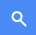

IndexError: list index out of range

In [42]:
print(soup.prettify())
#book = soup.find(attrs={'class':'bHexk Tz5Hvf'})
#book = soup.find('bHexk Tz5Hvf')
book = soup.find_all('books?id')

#link = book.find_all('http')
print(book[n])

In [ ]:
###THIS IS THE FULL SCRAPE OF A PAGE###

def Get_GBooks(titles):
    
    firsturl = 'https://www.google.com/search?tbm=bks&q=\'{} movie tie in'
        
    # Request the page and use BeautifulSoup to extract the contents
    page = requests.get(firsturl)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    #get title
    title = soup.find(attrs={'data-testid':'hero-title-block__title'})
    title = findtext(title)

    #get release date and rating (PG, PG13, etc)
    DR = soup.find_all(attrs={'class':'TitleBlockMetaData__ListItemText-sc-12ein40-2 jedhex'})
    if DR is not None:
        if len(DR)==2:
            date = findtext(DR[0])
            rating = findtext(DR[1])
        else:
            date = findtext(DR)
            rating = None
    else:
        date = None
        rating = None

    #get a list of genres
    gen = soup.find(attrs={'data-testid':'storyline-genres'}) 
    if gen is not None:
        gen = gen.find_all('a')
        genres =''
        for t in range(len(gen)):
            genres = genres + findtext(gen[t]) + ' '
    else:
        genres = None

    #get box office info
    #budget often has '(estimated)' in it
    box = soup.find(attrs={'data-testid':'title-boxoffice-section'})
    if box is not None:
        budget = box.find(attrs={'data-testid':'title-boxoffice-budget'}) 
        budget = str(budget)
        budget = findmoney(budget)
        dom = box.find(attrs={'data-testid':'title-boxoffice-grossdomestic'})
        dom = findmoney(dom)
        ww = soup.find(attrs={'data-testid':'title-boxoffice-cumulativeworldwidegross'}) 
        ww = findmoney(ww)
    else:
        budget = None
        dom = None
        ww = None

    
    story = soup.find(attrs={'data-testid':'Storyline'}) 
    if story is not None:
        #get the description
        desc = story.find(attrs={'class':'ipc-html-content ipc-html-content--base'})
        if desc is not None:
            desc = desc.div
            desc = findtext(desc)
        else:
            desc = ''
        #get top tags
        #only shows top few tags, usually list tag is to full list which can be in hundreds
        kw = story.find(attrs={'data-testid':'storyline-plot-keywords'}) 
        if kw is not None:
            kw = kw.find_all('span')
            keywords = ''
            for t in range(len(kw)):
                #keywords.append(findtext(kw[t]))
                keywords = keywords + findtext(kw[t]) + ' '
            #if 'more' in keywords[-1]:
                #keywords = keywords[:-1]
        else:
            keywords = None
    else:
        desc = None
        keywords = None

    #get runtime in minutes
    rt = soup.find(attrs={'data-testid':'title-techspec_runtime'}) 
    if rt is not None:
        rt = rt.find('div')
        hrs = findtext(rt)
        rt = str(rt)
        mins = rt[::-1]
        mins = mins[7:]
        mins = mins[mins.find('<')+1:mins.find('>', mins.find('<'), len(mins))]
        if hrs==' ':
            runtime = int(mins)
        elif mins==' ':
            runtime = int(hrs)*60
        else:
            runtime = int(hrs)*60 + int(mins)
    else:
        runtime = None

    #put all that info in a list and return it 
    obs = [title,date,rating, genres, budget,dom,ww,desc,keywords, runtime]
    
    return obs

In [ ]:
#ok now pull in our list of movies
#movies = pd.read_csv(r'C:\Users\maria\OneDrive\Documents\AIPI510\BooksToMoviesML\FilmList.csv') <--- original 2000-2021 list
movies = pd.read_csv(r'C:\Users\maria\OneDrive\Documents\AIPI510\BooksToMoviesML\FilmList2.csv')
movies = movies['Link']

#instantiate dataframe
data = pd.DataFrame(columns = ['Title', 'Release_Date', 'ViewRating', 'Genres', 'Budget', 'DomesticGross', 
                              'WorldwideGross', 'Description', 'Keywords', 'Runtime'])

#scrape provided pages
#this counter is because i had to run it in batches
movies = movies[4610:]

for this in movies:
    #print(this)
    obs = Get_Movie('https://www.imdb.com{}'.format(this))
    data.loc[len(data)] = obs

In [ ]:
print(data.info())